In [25]:
import numpy as np
import glob
import torch
import matplotlib.pyplot as plt
import pandas as pd
import os

In [47]:
# LOAD DATA
data_dir = "../data/Ns100_SeqN100/"
model_dir = "../Elman_SGD/Remap_predloss/N100T100/"

hidden_weight_inits = ["he", "shift", "cyclic-shift", "cmh", "ctridiag"]
input_type = ["gaussian"]  # , "onehot"]

Wh_lists = []
model_paths = []
output_data = []

for h in hidden_weight_inits:
    for i in input_type:
        Wh_lists.append(glob.glob(model_dir + f"{h}/{i}/single-run/hidden-weights/*"))
        path = model_dir + f"{h}/{i}/single-run/Ns100_SeqN100_predloss_full.pth.tar"
        model_paths.append(path)
        output_data.append(torch.load(path))

In [48]:
model_paths

['../Elman_SGD/Remap_predloss/N100T100/he/gaussian/single-run/Ns100_SeqN100_predloss_full.pth.tar',
 '../Elman_SGD/Remap_predloss/N100T100/shift/gaussian/single-run/Ns100_SeqN100_predloss_full.pth.tar',
 '../Elman_SGD/Remap_predloss/N100T100/cyclic-shift/gaussian/single-run/Ns100_SeqN100_predloss_full.pth.tar',
 '../Elman_SGD/Remap_predloss/N100T100/cmh/gaussian/single-run/Ns100_SeqN100_predloss_full.pth.tar',
 '../Elman_SGD/Remap_predloss/N100T100/ctridiag/gaussian/single-run/Ns100_SeqN100_predloss_full.pth.tar']

In [49]:
def get_metrics_df(torch_data):
    metrics = torch_data["metrics"]
    met_df = pd.DataFrame(metrics)
    return met_df

In [50]:
# final loss and best epoch
def final_loss_and_epoch(torch_data, wh_type=None, i_type=None):
    loss_list = torch_data["loss"]
    final_loss = loss_list[-1]
    best_epoch = loss_list.index(min(loss_list))
    best_loss = float(min(loss_list))
    if wh_type and i_type is not None:
        print(wh_type.upper(), i_type.upper())
    print(
        f"Final loss: {final_loss:.6f} | Best loss: {best_loss:.6f} at epoch {best_epoch}"
    )

    # return loss_list, final_loss, best_epoch, best_loss

In [51]:
d_i = 0
for h_i in range(len(hidden_weight_inits)):
    for i_i in range(len(input_type)):
        final_loss_and_epoch(
            output_data[d_i], wh_type=hidden_weight_inits[h_i], i_type=input_type[i_i]
        )
        print()
        d_i += 1

HE GAUSSIAN
Final loss: 0.004846 | Best loss: 0.004846 at epoch 48179

SHIFT GAUSSIAN
Final loss: 0.004869 | Best loss: 0.004869 at epoch 42969

CYCLIC-SHIFT GAUSSIAN
Final loss: 0.004795 | Best loss: 0.004795 at epoch 43234

CMH GAUSSIAN
Final loss: 0.006874 | Best loss: 0.006874 at epoch 49999

CTRIDIAG GAUSSIAN
Final loss: 0.146385 | Best loss: 0.146385 at epoch 3146



He and shift hidden weight initialization reach a similar final loss, although shift is able to do it ~5k epochs sooner. Cyclic shift was able to reach a lower loss with a similar number of epochs to standard shift. One-hot initialization was worse than Gaussian.

In [31]:
def plot_loss(torch_data, wh_type=None, i_type=None):
    loss_list = torch_data["loss"]
    plt.figure(figsize=(6, 3))
    plt.plot(loss_list, lw=2)
    plt.xlabel("Epoch")
    plt.ylabel("Train loss")
    if wh_type and i_type is not None:
        plt.title(f"Training Loss ({wh_type}, {i_type})")
    else:
        plt.title("Training Loss")
    plt.tight_layout()
    plt.show()

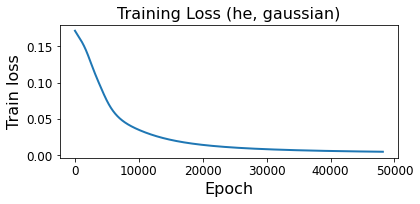

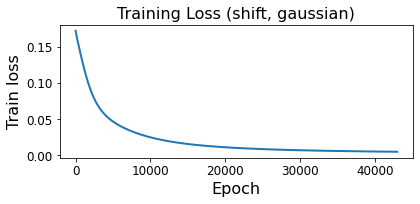

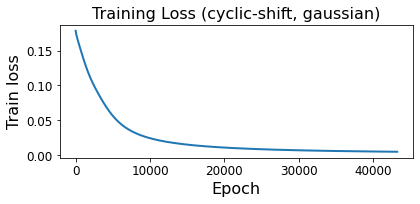

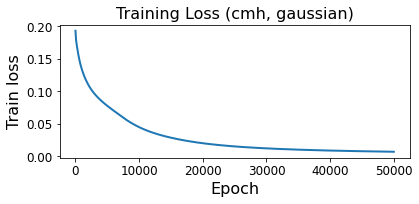

In [32]:
d_i = 0
for h_i in range(len(hidden_weight_inits)):
    for i_i in range(len(input_type)):
        plot_loss(
            output_data[d_i],
            wh_type=hidden_weight_inits[h_i],
            i_type=input_type[i_i],
        )
        print()
        d_i += 1

Shift loss and even moreso cyclic shift drop more sharply at the start then flattens with faster convergence compared to He initialization. This indicated that the structured initialization gives the RNN a built-in inductive bias.

In [33]:
def plot_grad_norm(torch_data, wh_type=None, i_type=None):
    history = torch_data["history"]
    plt.figure(figsize=(6, 3))
    plt.plot(history["epoch"], history["grad_norm"], marker="o")
    plt.xlabel("Epoch (recorded)")
    plt.ylabel("Grad norm (L2)")
    if wh_type and i_type is not None:
        plt.title(f"Gradient Norm (recorded epochs) ({wh_type}, {i_type})")
    else:
        plt.title("Gradient Norm (recorded epochs)")
    plt.tight_layout()
    plt.show()

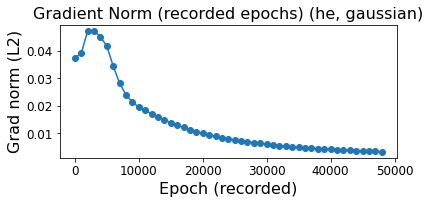

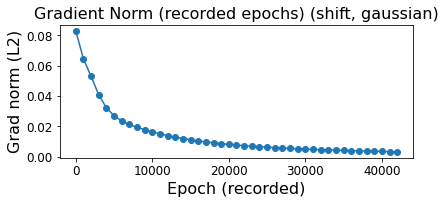

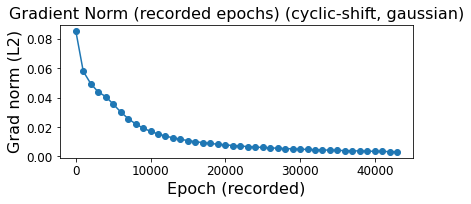

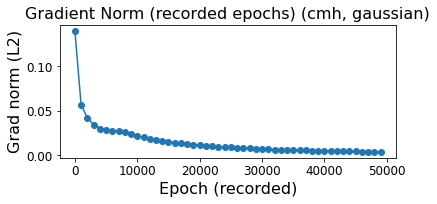

In [34]:
d_i = 0
for h_i in range(len(hidden_weight_inits)):
    for i_i in range(len(input_type)):
        plot_grad_norm(
            output_data[d_i],
            wh_type=hidden_weight_inits[h_i],
            i_type=input_type[i_i],
        )
        print()
        d_i += 1

He initialization has an early spike/overshoot followed by a long, smooth decay. The random eigenspectrum in He initialization gives mixed time scales, so the optimizer has to search more before settling. Due to more transient saturation and unstable directions, it needs more steps to stabilize. The shift initialization has a fast monotopic drop. The structured "conveyer belt" dynamics given an immediate bias for propgration, so gradients shrink quickly. The kink in the tail reflects learning to fix edge effects because of the boundaries in non-cyclic shift. The cyclic shift initialization has the fastest, smoothest decay. Being a permutation matrix (eigs on the unit circle) avoids edge effects and preserves signal energy uniformly around the ring leading to well-conditioned updates and minimal transient wobble.

In [35]:
def plot_metrics(torch_data, wh_type=None, i_type=None):
    met_df = get_metrics_df(torch_data)
    fig, axes = plt.subplots(2, 4, figsize=(16, 7), constrained_layout=True)
    axes = axes.ravel()

    # Define 7 line plots
    plots = [
        ("drift_from_init", "‖W_h − W_h(0)‖_F"),
        ("frob", "‖W_h‖_F"),
        ("spectral_radius", "Spectral radius ρ(W_h)"),
        ("orth_err", "‖W_hᵀ W_h − I‖_F"),
        ("act_mean", "mean(h)"),
        ("act_std", "std(h)"),
        ("tanh_sat", "tanh saturation frac"),
    ]
    i = 0

    for col, ylabel in plots:
        if (
            col in met_df.columns and met_df[col].notna().any() and i < len(axes) - 1
        ):  # leave last slot for scatter
            ax = axes[i]
            i += 1
            ax.plot(met_df["epoch"], met_df[col], marker="o")
            ax.set_title(ylabel)
            ax.set_xlabel("Epoch")
            ax.set_ylabel(ylabel)

    # Last panel: scatter Loss vs spectral radius (if available)
    if i < len(axes) and {"spectral_radius", "loss"}.issubset(met_df.columns):
        ax = axes[i]
        i += 1
        ax.scatter(met_df["spectral_radius"], met_df["loss"], s=20)
        ax.set_title("Loss vs ρ(W_h)")
        ax.set_xlabel("Spectral radius ρ(W_h)")
        ax.set_ylabel("Loss")

    # Turn off any leftover empty axes
    for k in range(i, len(axes)):
        axes[k].axis("off")

    if wh_type and i_type is not None:
        plt.suptitle(f"Hidden Weight Dynamics ({wh_type}, {i_type})")
    else:
        plt.suptitle("Hidden Weight Dynamics")
    plt.show()

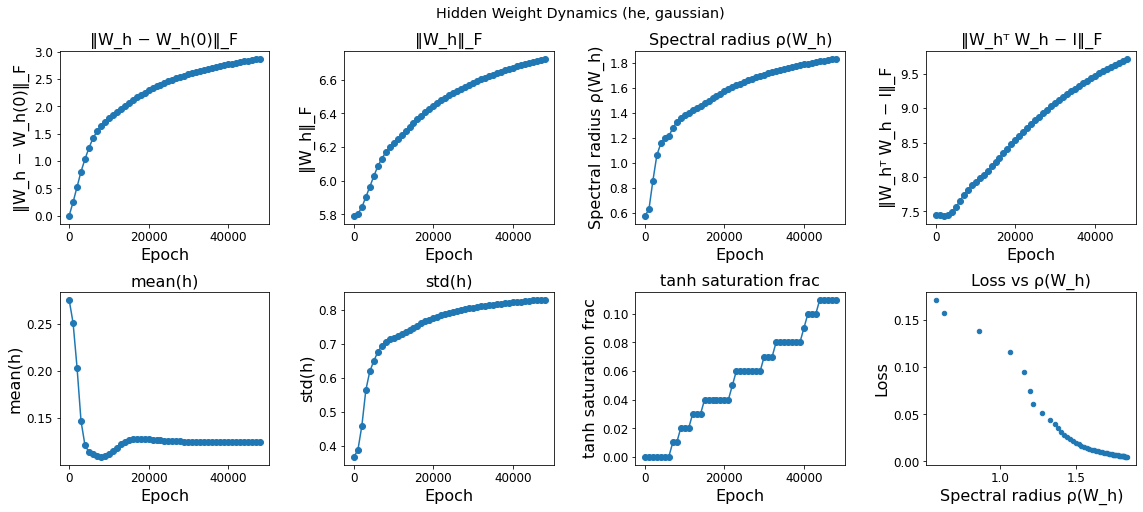

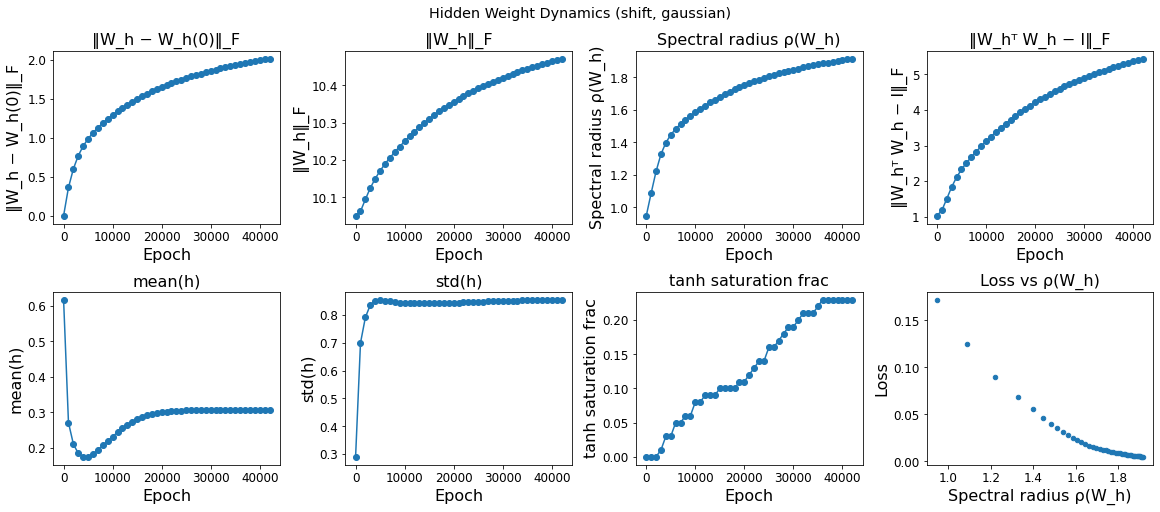

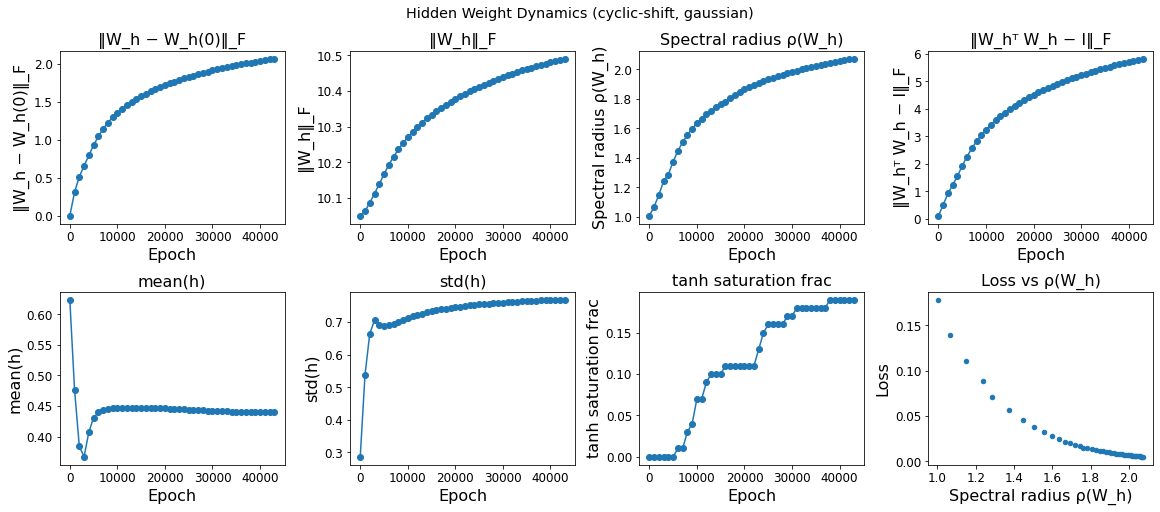

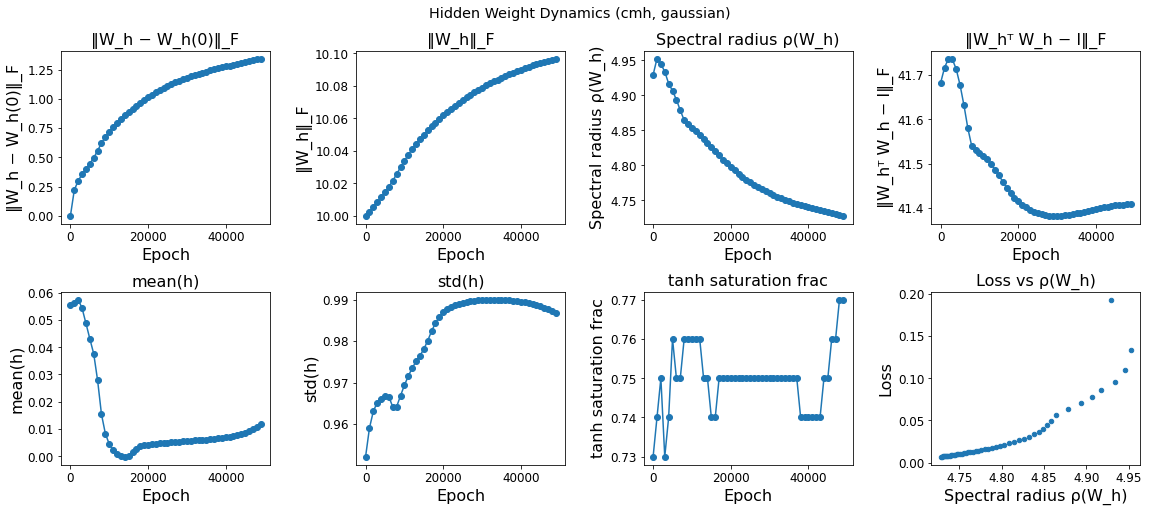

In [36]:
d_i = 0
for h_i in range(len(hidden_weight_inits)):
    for i_i in range(len(input_type)):
        plot_metrics(
            output_data[d_i],
            wh_type=hidden_weight_inits[h_i],
            i_type=input_type[i_i],
        )
        print()
        d_i += 1

In [37]:
def show_predictions(torch_data, wh_type=None, i_type=None):
    history = torch_data["history"]
    y_hat = history["y_hat"][-1].numpy()
    y_true = history["Target_mini"][-1].numpy()
    b = 0
    chans = list(range(min(3, y_hat.shape[-1])))
    for ch in chans:
        plt.figure(figsize=(7, 2.5))
        plt.plot(y_true[b, :, ch], label="target")
        plt.plot(y_hat[b, :, ch], label="pred", alpha=0.8)
        if wh_type and i_type is not None:
            plt.title(f"Recorded minibatch – neuron {ch} ({wh_type}, {i_type})")
        else:
            plt.title(f"Recorded minibatch – neuron {ch}")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()
        plt.tight_layout()
        plt.show()

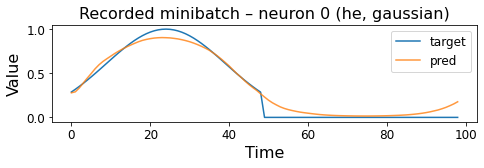

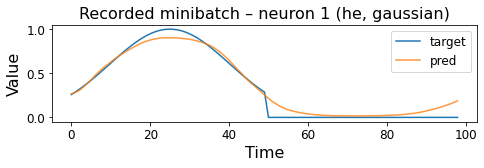

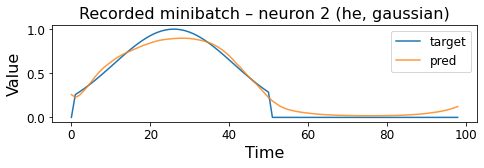

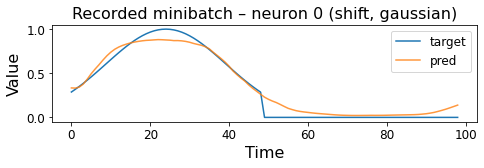

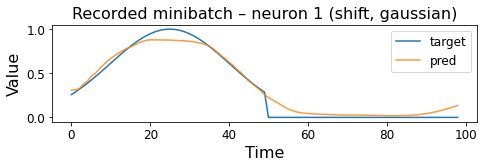

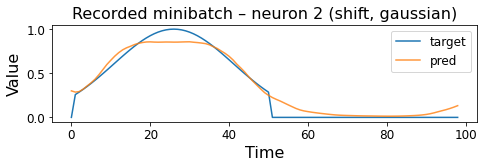

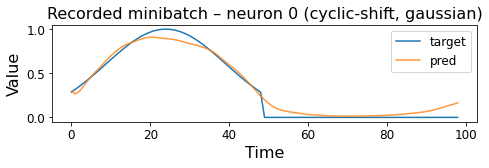

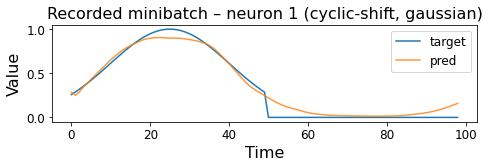

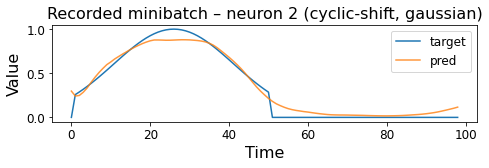

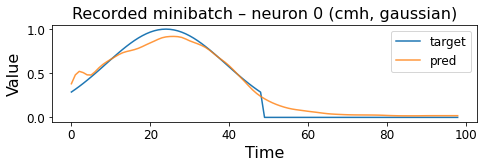

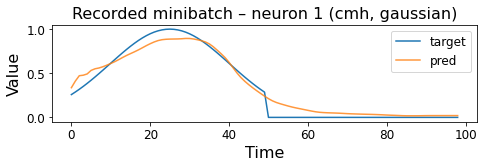

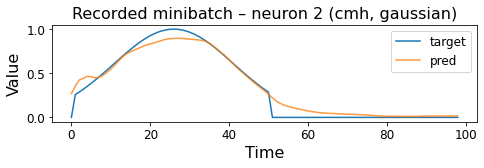

In [38]:
d_i = 0
for h_i in range(len(hidden_weight_inits)):
    for i_i in range(len(input_type)):
        show_predictions(
            output_data[d_i],
            wh_type=hidden_weight_inits[h_i],
            i_type=input_type[i_i],
        )
        print()
        d_i += 1

In [39]:
def show_weight(W, title="W"):
    vmax = float(torch.max(torch.abs(W)))
    plt.figure(figsize=(4, 3))
    plt.imshow(
        W, origin="upper", aspect="auto", vmin=-vmax, vmax=vmax, interpolation=None
    )
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()


def pick_paths(Wh_paths):
    # sample a few epochs (start, middle, end)
    pick = []
    if Wh_paths:
        pick = [Wh_paths[0], Wh_paths[len(Wh_paths) // 2], Wh_paths[-1]]

    return pick

In [40]:
def eigvals_compat(W):
    try:
        return torch.linalg.eigvals(W).cpu().numpy()
    except AttributeError:
        reim, _ = torch.eig(W, eigenvectors=False)
        return reim[:, 0].numpy() + 1j * reim[:, 1].numpy()

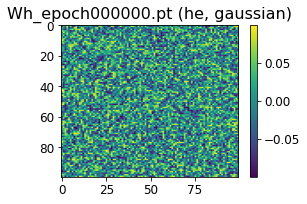

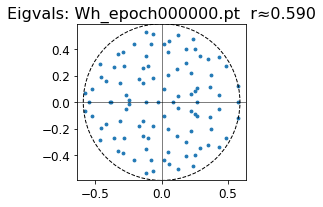

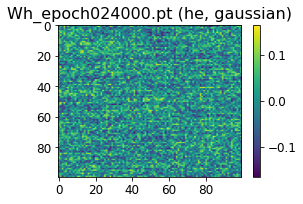

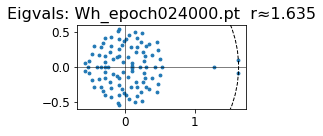

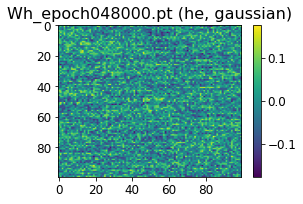

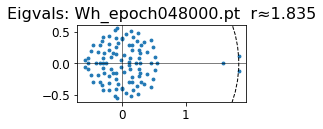

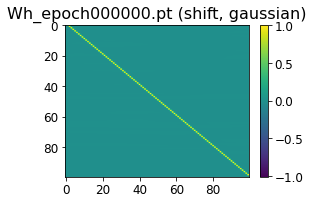

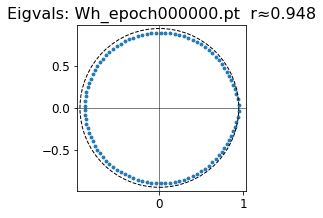

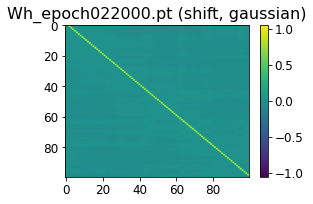

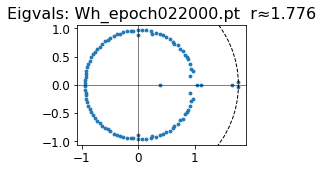

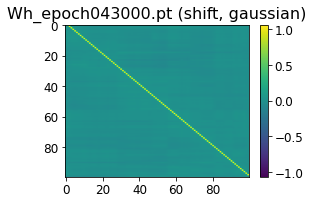

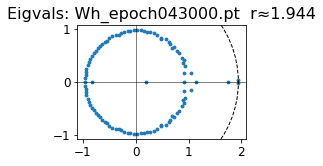

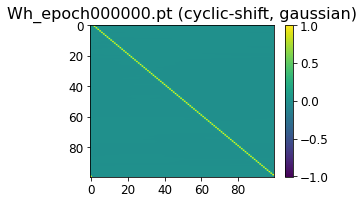

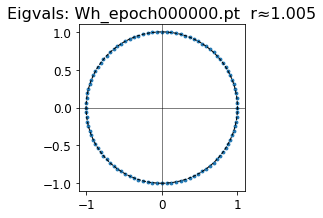

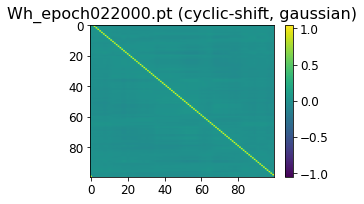

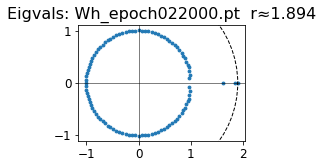

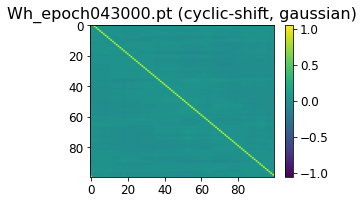

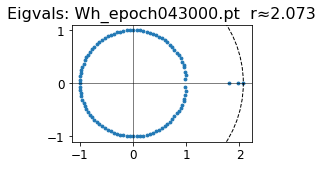

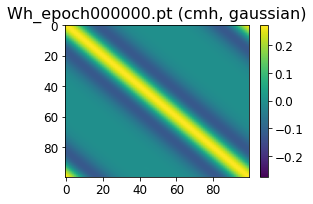

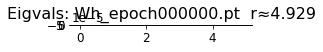

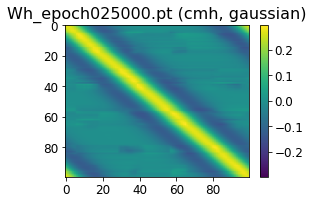

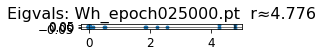

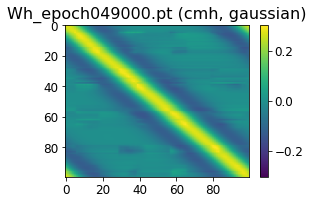

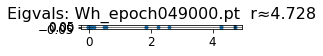

In [41]:
d_i = 0
for h_i in range(len(hidden_weight_inits)):
    for i_i in range(len(input_type)):
        pick = pick_paths(Wh_lists[d_i])

        for p in pick:
            Wh = torch.load(p, map_location="cpu")
            title = os.path.basename(p)
            title = title + f" ({hidden_weight_inits[h_i]}, {input_type[i_i]})"
            show_weight(Wh, title=title)

            ev = eigvals_compat(Wh)
            r = np.max(np.abs(ev))
            plt.figure(figsize=(3.2, 3.2))
            plt.scatter(ev.real, ev.imag, s=8)
            circle = plt.Circle((0, 0), r, fill=False, ls="--")
            plt.gca().add_artist(circle)
            plt.axhline(0, lw=0.5, c="k")
            plt.axvline(0, lw=0.5, c="k")
            plt.gca().set_aspect("equal", "box")
            plt.title(f"Eigvals: {os.path.basename(p)}  r≈{r:.3f}")
            plt.tight_layout()
            plt.show()
        d_i += 1

## Prediction and Replay analysis
From Yusi's code

In [42]:
import sys

sys.path.append("../")
from RNN_Class import *

In [43]:
def replay(model_path, wh_type=None, i_type=None):
    """
    Visualize 'replay' in trained predictive recurrent autoencoder.

    This function loads the trained model, runs the model once on true inputs. Constructs a low-magnitude random input (noise) meant to mimic spontaneous activity, then runs the model on this noise to see if it 'replays' a learned pattern.
    """
    # set parameters
    N, SeqN, HN = 100, 100, 100

    # load input data
    data_path = "../data/Ns100_SeqN100/"
    data_name = "Ns{}_SeqN{}_1".format(N, SeqN)
    data = torch.load(data_path + data_name + ".pth.tar")
    X_mini = data["X_mini"][:, :-1, :]
    Target_mini = data["Target_mini"][:, 1:, :]

    # load trained modelN)
    model = ElmanRNN_tp1(N, HN, N)
    model.act = nn.Sigmoid()
    net = torch.load(model_path, map_location="cuda:0")
    model.load_state_dict(net["state_dict"])

    # noise as input
    X_noise = np.random.normal(0, 1, X_mini.shape) * X_mini.numpy().max() * 0.01
    X_noise = torch.tensor(X_noise.astype(np.single))

    # forward pass with real inputs
    output_null, _ = model(X_noise, torch.zeros((1, 1, HN)))
    Target_p = Target_mini[0, :, :].T
    output_p = output_null.detach().numpy()[0, :, :].T
    title_list = [
        "Input current ($x_t$)",
        "Target output ($y_t$)",
        "Output after training ($\hat{y_t}$)",
    ]
    vmax_list = np.array([X_noise.max(), Target_p.max(), output_p.max()])
    print(X_noise.shape)

    # show one sequence
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    data = [X_noise[0, :, :], Target_p, output_p]

    for i in range(3):
        axes[i].imshow(data[i])
        axes[i].set_title(title_list[i])

    if wh_type and i_type is not None:
        plt.suptitle(f"Replay ({wh_type}, {i_type})")
    else:
        plt.suptitle("Replay")
    plt.tight_layout()
    # print("vmax_list", vmax_list)
    plt.show()

In [44]:
def prediction(model_path, wh_type=None, i_type=None):
    """
    Visualize 'prediction' in trained predictive recurrent autoencoder.

    This function loads the trained model, runs the model once on true inputs. Constructs a low-magnitude random input (noise) meant to mimic spontaneous activity, then runs the model on this noise to see if it 'replays' a learned pattern.
    """
    # set parameters
    N, SeqN, HN = 100, 100, 100

    # load input data
    data_path = "../data/Ns100_SeqN100/"
    data_name = "Ns{}_SeqN{}_1".format(N, SeqN)
    data = torch.load(data_path + data_name + ".pth.tar")
    X_mini = data["X_mini"][:, :-1, :]
    Target_mini = data["Target_mini"][:, 1:, :]
    Target_p = Target_mini[0, :, :].T

    # load trained model
    model = ElmanRNN_tp1(N, HN, N)
    model.act = nn.Sigmoid()
    net = torch.load(model_path, map_location="cuda:0")
    model.load_state_dict(net["state_dict"])

    # noise as input (stops after 10 time steps)
    X_noise = np.random.normal(0, 1, X_mini.shape) * X_mini.numpy().max() * 0.01
    X_noise = torch.tensor(X_noise.astype(np.single))
    X_noise[:, :10, :] = X_mini[:, :10, :]

    # forward pass with real inputs
    output_null, _ = model(X_noise, torch.zeros((1, 1, HN)))
    output_p = output_null.detach().numpy()[0, :, :].T
    title_list = [
        "Input current ($x_t$)",
        "Target output ($y_t$)",
        "Output after training ($\hat{y_t}$)",
    ]
    vmax_list = np.array([X_noise.max(), Target_p.max(), output_p.max()])

    # show one sequence
    figs, axes = plt.subplots(1, 3, figsize=(10, 5))
    data = [X_noise[0, :, :], Target_p, output_p]

    for i in range(3):
        axes[i].imshow(data[i])
        axes[i].set_title(title_list[i])

    if wh_type and i_type is not None:
        plt.suptitle(f"Prediction ({wh_type}, {i_type})")
    else:
        plt.suptitle("Prediction")
    plt.tight_layout()
    plt.show()

In [45]:
def weight_trace(model_path, wh_type=None, i_type=None):
    # set parameters
    N, SeqN, HN = 100, 100, 100

    # load input data
    data_path = "../data/Ns100_SeqN100/"
    data_name = "Ns{}_SeqN{}_1".format(N, SeqN)
    data = torch.load(data_path + data_name + ".pth.tar")
    X_mini = data["X_mini"][:, :-1, :]

    # load trained model
    model = ElmanRNN_tp1(N, HN, N)
    model.act = nn.Sigmoid()
    net = torch.load(model_path, map_location="cuda:0")
    model.load_state_dict(net["state_dict"])
    W = net["state_dict"]["hidden_linear.weight"].cpu().numpy()

    # build hidden weights
    hidden = np.zeros((HN, SeqN - 1))
    output = np.zeros((N, SeqN - 1))
    h = torch.zeros(1, 1, HN)
    for t in np.arange(SeqN - 1):
        o, h = model(X_mini[0:1, t : t + 1, :], h)
        hidden[:, t] = h.detach().numpy()[0, 0, :]
        output[:, t] = o.detach().numpy()[0, 0, :]

    c_max = np.abs(W).max()

    # sort neurons by time step of max activation
    sort_idx = np.argsort(np.argmax(hidden, axis=1))
    offset_list = np.arange(-N, N + 1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Left: W sorted
    ax = axes[0]
    ax.imshow(
        W[sort_idx, :][:, sort_idx],
        cmap="RdBu_r",
        vmin=-1.001 * c_max,
        vmax=1.001 * c_max,
        aspect="auto",
    )
    crange = [-c_max, 0, c_max]
    cbar = fig.colorbar(ax.images[0], ax=ax, ticks=crange, fraction=0.046, pad=0.04)
    cbar.ax.set_yticklabels([f"{v:.3f}" for v in crange])
    ax.set_xlabel("Presynaptic neuron")
    ax.set_ylabel("Postsynaptic neuron")
    if wh_type and i_type is not None:
        ax.set_title(f"W sorted by hidden activity ({wh_type}, {i_type})")
    else:
        ax.set_title("W sorted by hidden activity")

    # Right: diagonal-offset trace
    W_sorted = W[sort_idx, :][:, sort_idx]
    trace_vals = np.array([np.trace(W_sorted, offset=k) for k in offset_list])
    ax = axes[1]
    ax.plot(offset_list, trace_vals, label="Env1")
    ax.axhline(y=0, color="r", linestyle="--", linewidth=1)
    ax.set_xlabel("Diagonal offset")
    ax.set_ylabel(
        "Weight sum"
    )  # was "Weight avg." but code uses sum; change if you normalize
    if wh_type and i_type is not None:
        ax.set_title(f"Diagonal-offset trace ({wh_type}, {i_type})")
    else:
        ax.set_title("Diagonal-offset trace")
    ax.legend()

    plt.rc("font", size=12)
    plt.rc("axes", titlesize=16, labelsize=16)
    plt.tight_layout()
    plt.show()

../Elman_SGD/Remap_predloss/N100T100/he/gaussian/single-run/Ns100_SeqN100_predloss_full.pth.tar
torch.Size([1, 99, 100])


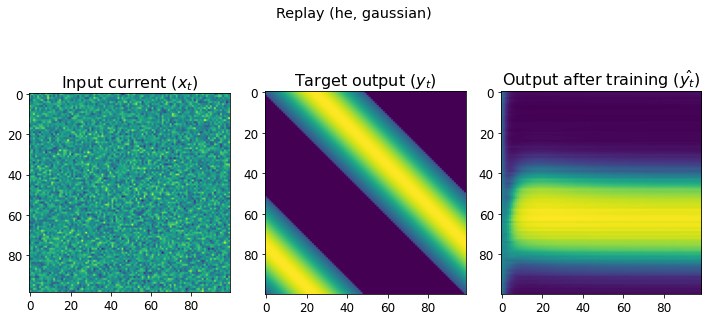

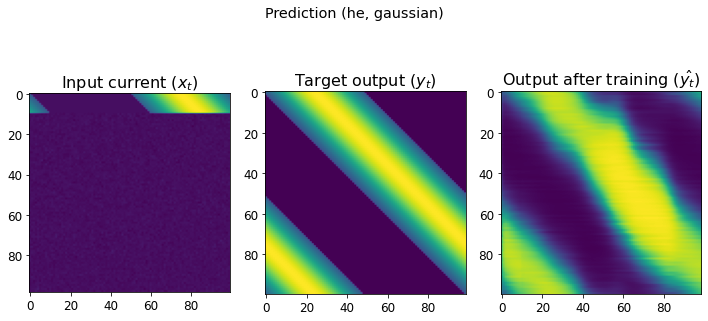

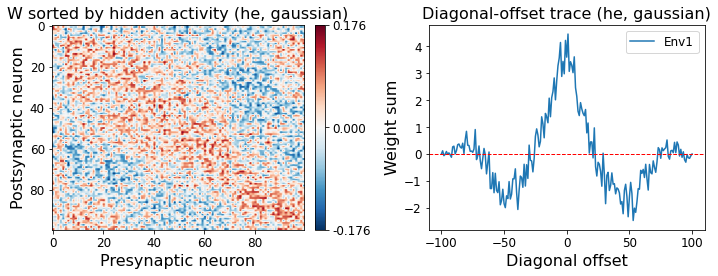


../Elman_SGD/Remap_predloss/N100T100/shift/gaussian/single-run/Ns100_SeqN100_predloss_full.pth.tar
torch.Size([1, 99, 100])


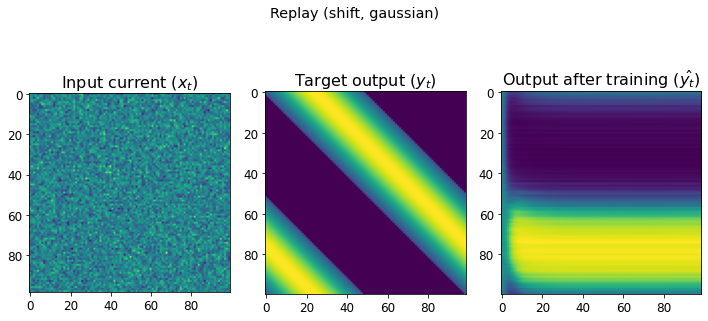

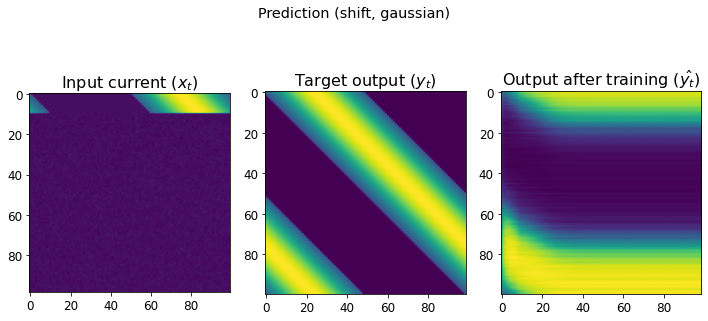

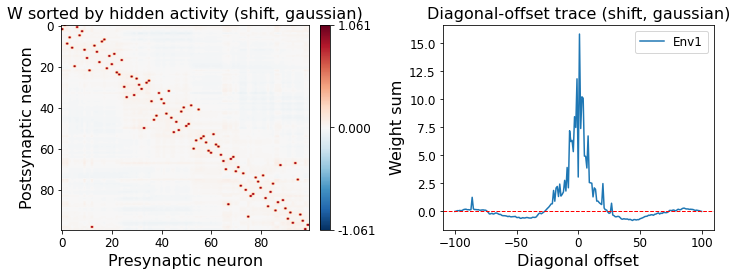


../Elman_SGD/Remap_predloss/N100T100/cyclic-shift/gaussian/single-run/Ns100_SeqN100_predloss_full.pth.tar
torch.Size([1, 99, 100])


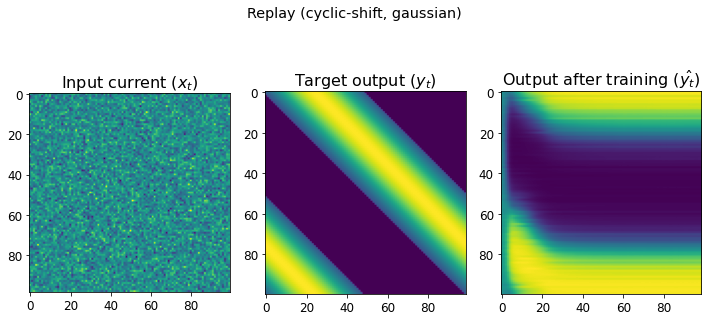

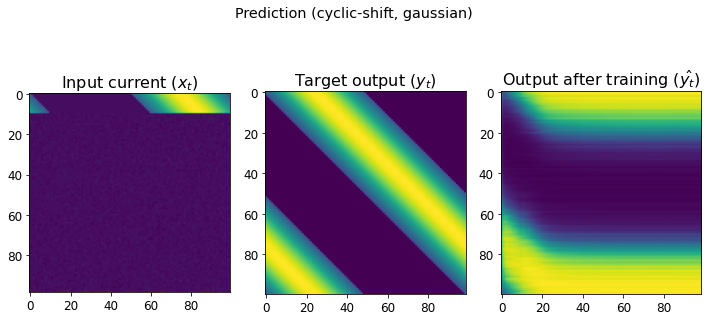

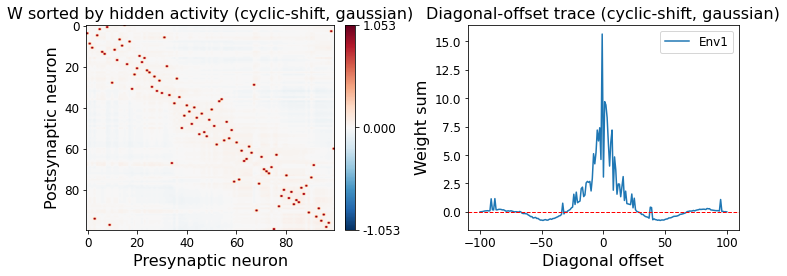


../Elman_SGD/Remap_predloss/N100T100/cmh/gaussian/single-run/Ns100_SeqN100_predloss_full.pth.tar
torch.Size([1, 99, 100])


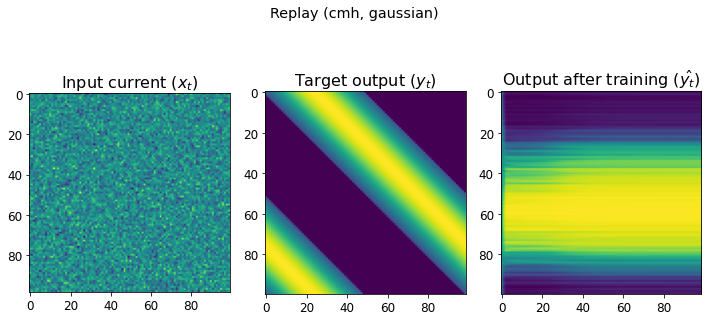

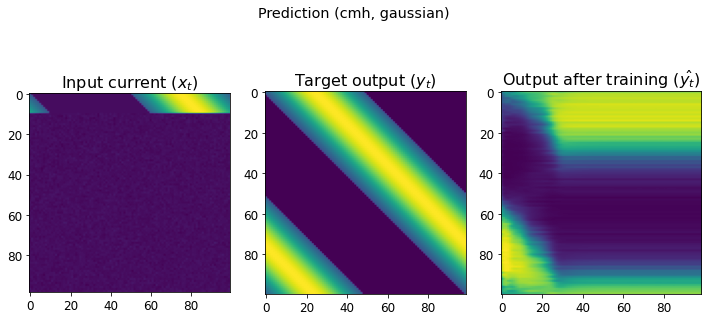

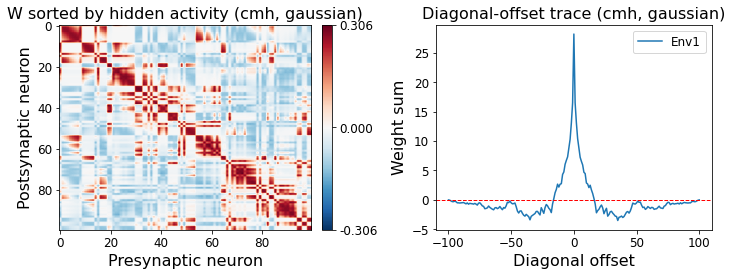

In [46]:
d_i = 0
for h_i in range(len(hidden_weight_inits)):
    for i_i in range(len(input_type)):
        model_path = model_paths[d_i]
        print(model_path)
        replay(
            model_path=model_path,
            wh_type=hidden_weight_inits[h_i],
            i_type=input_type[i_i],
        )
        prediction(
            model_path=model_path,
            wh_type=hidden_weight_inits[h_i],
            i_type=input_type[i_i],
        )
        weight_trace(
            model_path=model_path,
            wh_type=hidden_weight_inits[h_i],
            i_type=input_type[i_i],
        )
        print()
        d_i += 1